House Price Prediction

Dataset - California Housing Prices - .data/housing.csv

1. Install and Import the required libraries

In [1]:
%pip install -r ../requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import (
    root_mean_squared_error)

In [3]:
#Notebook Configurations

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f"{x:.3f}")
sns.set_theme(style='darkgrid')

plt.rcParams.update({
    "axes.titlesize": 10,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
})

RANDOM_STATE = 42
CSV_PATH = "../data/housing.csv"
TARGET_COL = "median_house_value"

2. LOAD DATA

In [4]:
df = pd.read_csv(CSV_PATH)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.230,37.880,41.000,880.000,129.000,322.000,126.000,8.325,452600.000,NEAR BAY
1,-122.220,37.860,21.000,7099.000,1106.000,2401.000,1138.000,8.301,358500.000,NEAR BAY
2,-122.240,37.850,52.000,1467.000,190.000,496.000,177.000,7.257,352100.000,NEAR BAY
3,-122.250,37.850,52.000,1274.000,235.000,558.000,219.000,5.643,341300.000,NEAR BAY
4,-122.250,37.850,52.000,1627.000,280.000,565.000,259.000,3.846,342200.000,NEAR BAY


3. Exploratory Data Analysis(EDA)

In [7]:
num_col = df.select_dtypes(include=[np.number]).columns.tolist()
cat_col = df.select_dtypes(include="object").columns.tolist()

print("Target Column:", TARGET_COL)
print("Numerical Columns:", num_col)
print("Categorical Columns:", cat_col)  

Target Column: median_house_value
Numerical Columns: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
Categorical Columns: ['ocean_proximity']


In [8]:
#missing values analysis

print("Missing Values Analysis: \n", df.isnull().sum())

Missing Values Analysis: 
 longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


In [9]:
#check presense of enccoded missing values
for col in df.columns:
    print(df[col].value_counts().head(20))

longitude
-118.310    162
-118.300    160
-118.290    148
-118.270    144
-118.320    142
-118.280    141
-118.350    140
-118.360    138
-118.190    135
-118.250    128
-118.370    128
-118.200    126
-118.140    125
-118.260    121
-118.130    121
-118.180    120
-118.340    119
-118.210    118
-118.150    116
-118.120    112
Name: count, dtype: int64
latitude
34.060    244
34.050    236
34.080    234
34.070    231
34.040    221
34.090    212
34.020    208
34.100    203
34.030    193
33.930    181
33.940    175
33.970    172
33.990    168
33.880    164
33.980    162
34.110    162
34.160    159
34.120    158
34.150    157
34.010    156
Name: count, dtype: int64
housing_median_age
52.000    1273
36.000     862
35.000     824
16.000     771
17.000     698
34.000     689
26.000     619
33.000     615
18.000     570
25.000     566
32.000     565
37.000     537
15.000     512
19.000     502
27.000     488
24.000     478
30.000     476
28.000     471
20.000     465
29.000     461
Name: coun

In [10]:
df[num_col].describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000,20640.000,20640.000,20640.000,20433.000,20640.000,20640.000,20640.000,20640.000
mean,-119.570,35.632,28.639,2635.763,537.871,1425.477,499.540,3.871,206855.817
std,2.004,2.136,12.586,2181.615,421.385,1132.462,382.330,1.900,115395.616
min,-124.350,32.540,1.000,2.000,1.000,3.000,1.000,0.500,14999.000
25%,-121.800,33.930,18.000,1447.750,296.000,787.000,280.000,2.563,119600.000
50%,-118.490,34.260,29.000,2127.000,435.000,1166.000,409.000,3.535,179700.000
75%,-118.010,37.710,37.000,3148.000,647.000,1725.000,605.000,4.743,264725.000
max,-114.310,41.950,52.000,39320.000,6445.000,35682.000,6082.000,15.000,500001.000


Data Visualisation

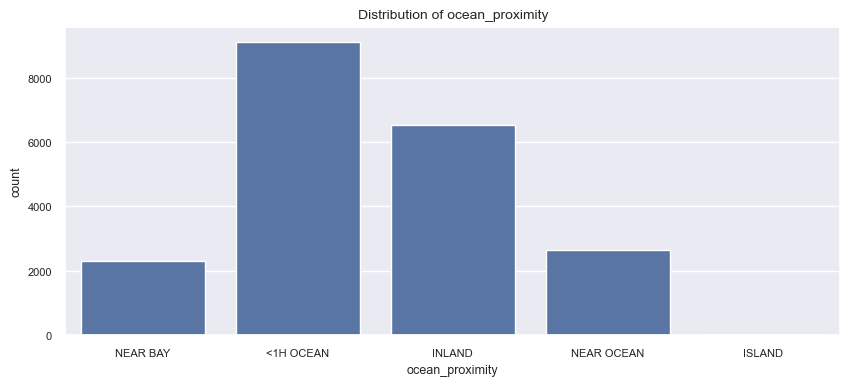

In [11]:
for col in cat_col:
    plt.figure(figsize=(10,4))
    sns.countplot(data=df, x=col)
    plt.title(f"Distribution of {col}")
    plt.show()  

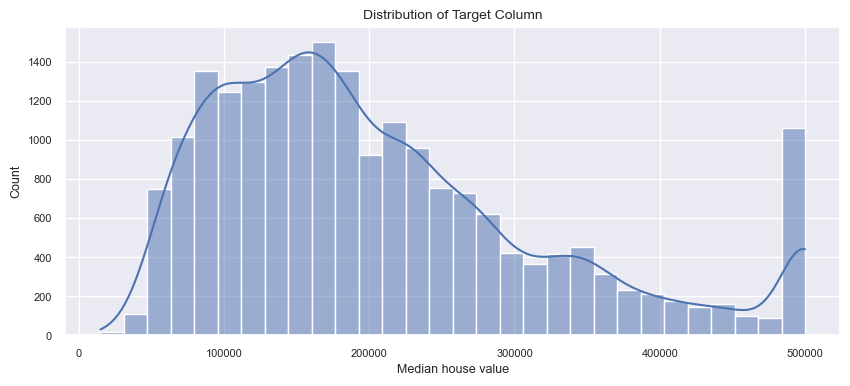

In [12]:
#target column distribution
plt.figure(figsize=(10,4))
sns.histplot(df[TARGET_COL], bins=30, kde=True)
plt.title("Distribution of Target Column")
plt.xlabel("Median house value")
plt.show()

In [13]:
df[TARGET_COL].value_counts()
#higher cap

median_house_value
500001.000    965
137500.000    122
162500.000    117
112500.000    103
187500.000     93
             ... 
34200.000       1
46200.000       1
352000.000      1
307900.000      1
385200.000      1
Name: count, Length: 3842, dtype: int64

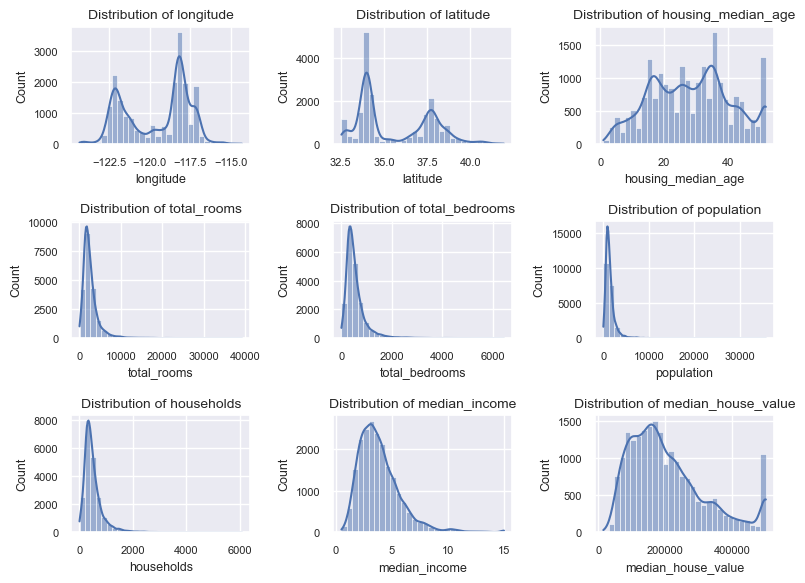

In [14]:
# histogram plot distrbution
fig, axes = plt.subplots(3,3, figsize=(8,6))
axes = axes.flatten()

for i, col in enumerate(num_col):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

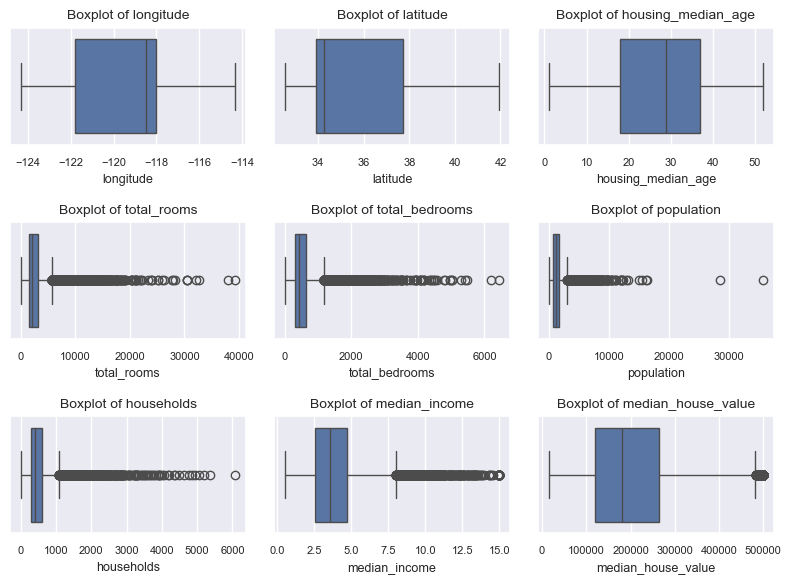

In [15]:
#outlier analysis - boxplot
fig, axes = plt.subplots(3,3, figsize=(8,6))
axes = axes.flatten()

for i, col in enumerate(num_col):
    sns.boxplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()

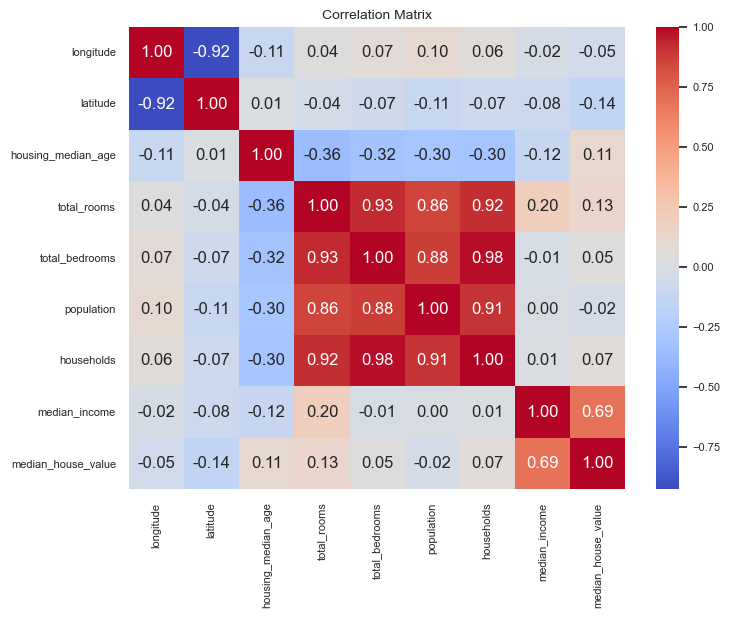

In [16]:
#indetify correlations

plt.figure(figsize=(8,6))
sns.heatmap(
    df[num_col].corr(), 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm"
    )
plt.title("Correlation Matrix")
plt.show()

In [17]:
#correlation with target column
correlation_target = df[num_col].corr()[TARGET_COL].sort_values(ascending=False)
print("Correlation with Target Column:\n", correlation_target)

Correlation with Target Column:
 median_house_value    1.000
median_income         0.688
total_rooms           0.134
housing_median_age    0.106
households            0.066
total_bedrooms        0.050
population           -0.025
longitude            -0.046
latitude             -0.144
Name: median_house_value, dtype: float64


4. Data Preprocessing 

In [18]:
#Separate features and target variable
X = df.drop(columns=[TARGET_COL])
Y = df[TARGET_COL]

In [19]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-122.230,37.880,41.000,880.000,129.000,322.000,126.000,8.325,NEAR BAY
1,-122.220,37.860,21.000,7099.000,1106.000,2401.000,1138.000,8.301,NEAR BAY
2,-122.240,37.850,52.000,1467.000,190.000,496.000,177.000,7.257,NEAR BAY
3,-122.250,37.850,52.000,1274.000,235.000,558.000,219.000,5.643,NEAR BAY
4,-122.250,37.850,52.000,1627.000,280.000,565.000,259.000,3.846,NEAR BAY


In [20]:
Y.head()

0   452600.000
1   358500.000
2   352100.000
3   341300.000
4   342200.000
Name: median_house_value, dtype: float64

In [21]:
#test train split
X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size=0.2,
    random_state=RANDOM_STATE)

In [22]:
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (16512, 9)
Testing set shape: (4128, 9)


In [23]:
print(X_train['ocean_proximity'].value_counts())
print(X_test['ocean_proximity'].value_counts())

ocean_proximity
<1H OCEAN     7341
INLAND        5227
NEAR OCEAN    2086
NEAR BAY      1854
ISLAND           4
Name: count, dtype: int64
ocean_proximity
<1H OCEAN     1795
INLAND        1324
NEAR OCEAN     572
NEAR BAY       436
ISLAND           1
Name: count, dtype: int64


Preprocessing Pipeline

In [24]:
numerical_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include="object").columns.tolist()

In [25]:
print("numerial features:", numerical_features)
print("categorical_features:", categorical_features)

numerial features: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
categorical_features: ['ocean_proximity']


Handling of Missing Data 
- Some features, like total_bedrooms, contain missing values. You can:

1. Drop rows with missing values
2. Drop the entire column
3. Impute missing values (recommended)
- We'll use option 3 using SimpleImputer from Scikit-Learn, which allows consistent handling across all datasets (train, test, new data)

In [26]:
imputer = SimpleImputer(strategy='median')


In [27]:
imputer.fit(X_train[numerical_features])

SimpleImputer(strategy='median')

In [28]:
X = imputer.transform(X_train[numerical_features])

In [29]:
X

array([[-1.1703e+02,  3.2710e+01,  3.3000e+01, ...,  2.3000e+03,
         6.2300e+02,  3.2596e+00],
       [-1.1816e+02,  3.3770e+01,  4.9000e+01, ...,  1.3140e+03,
         7.5600e+02,  3.8125e+00],
       [-1.2048e+02,  3.4660e+01,  4.0000e+00, ...,  9.1500e+02,
         3.3600e+02,  4.1563e+00],
       ...,
       [-1.1838e+02,  3.4030e+01,  3.6000e+01, ...,  1.7560e+03,
         5.2700e+02,  2.9344e+00],
       [-1.2196e+02,  3.7580e+01,  1.5000e+01, ...,  1.7770e+03,
         5.5900e+02,  5.7192e+00],
       [-1.2242e+02,  3.7770e+01,  5.2000e+01, ...,  2.6190e+03,
         1.2420e+03,  2.5755e+00]])

In [30]:
X_train[numerical_features] = pd.DataFrame(X, columns=numerical_features, index=X_train.index)

In [31]:
X_train.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
ocean_proximity       0
dtype: int64

Handling the Categorical Attributes

In [32]:
cat_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
cat_encoder.fit(X_train[categorical_features])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [33]:
X = cat_encoder.transform(X_train[categorical_features])

In [34]:
cat_columns = cat_encoder.get_feature_names_out(categorical_features)
cat_columns.tolist()

['ocean_proximity_<1H OCEAN',
 'ocean_proximity_INLAND',
 'ocean_proximity_ISLAND',
 'ocean_proximity_NEAR BAY',
 'ocean_proximity_NEAR OCEAN']

In [35]:
X_train[cat_columns.tolist()] = pd.DataFrame(X, columns=cat_columns.tolist(), index=X_train.index)

In [36]:
X_train.tail()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
11284,-117.960,33.780,35.000,1330.000,201.000,658.000,217.000,6.370,<1H OCEAN,1.000,0.000,0.000,0.000,0.000
11964,-117.430,34.020,33.000,3084.000,570.000,1753.000,449.000,3.050,INLAND,0.000,1.000,0.000,0.000,0.000
5390,-118.380,34.030,36.000,2101.000,569.000,1756.000,527.000,2.934,<1H OCEAN,1.000,0.000,0.000,0.000,0.000
860,-121.960,37.580,15.000,3575.000,597.000,1777.000,559.000,5.719,<1H OCEAN,1.000,0.000,0.000,0.000,0.000
15795,-122.420,37.770,52.000,4226.000,1315.000,2619.000,1242.000,2.575,NEAR BAY,0.000,0.000,0.000,1.000,0.000


In [37]:
X_train.drop(columns=categorical_features, inplace=True)

In [38]:
X_train.tail()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
11284,-117.960,33.780,35.000,1330.000,201.000,658.000,217.000,6.370,1.000,0.000,0.000,0.000,0.000
11964,-117.430,34.020,33.000,3084.000,570.000,1753.000,449.000,3.050,0.000,1.000,0.000,0.000,0.000
5390,-118.380,34.030,36.000,2101.000,569.000,1756.000,527.000,2.934,1.000,0.000,0.000,0.000,0.000
860,-121.960,37.580,15.000,3575.000,597.000,1777.000,559.000,5.719,1.000,0.000,0.000,0.000,0.000
15795,-122.420,37.770,52.000,4226.000,1315.000,2619.000,1242.000,2.575,0.000,0.000,0.000,1.000,0.000


Feature Scaling

In [39]:
std_scalar = StandardScaler()

In [40]:
X = std_scalar.fit_transform(X_train)

In [41]:
X_train = pd.DataFrame(X, columns=X_train.columns, index=X_train.index)

In [42]:
X_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
14196,1.273,-1.373,0.348,0.223,0.211,0.768,0.323,-0.326,-0.895,-0.681,-0.016,-0.356,2.630
8267,0.709,-0.877,1.618,0.340,0.593,-0.099,0.672,-0.036,-0.895,-0.681,-0.016,-0.356,2.630
17445,-0.448,-0.460,-1.953,-0.343,-0.495,-0.450,-0.430,0.145,-0.895,-0.681,-0.016,-0.356,2.630
14265,1.233,-1.382,0.587,-0.561,-0.409,-0.007,-0.381,-1.018,-0.895,-0.681,-0.016,-0.356,2.630
2271,-0.109,0.532,1.142,-0.120,-0.257,-0.486,-0.315,-0.171,-0.895,1.469,-0.016,-0.356,-0.380


5. Constructing the Pipeline

In [43]:
#Numerical attribute pipeline
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='median')),
    ("scaler", StandardScaler())
    ])

#Categorical attribute pipeline
cat_pipeline = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [45]:
#Construct the Full Pipeline
pipeline = ColumnTransformer([
    ("num", num_pipeline, numerical_features), 
    ("cat", cat_pipeline, categorical_features)
    ])

X_test_prepared = pipeline.fit_transform(X_test)
X_test_prepared = pd.DataFrame(X_test_prepared, columns=pipeline.get_feature_names_out(), index=X_test.index)
X_test_prepared.head()

,num__longitude,num__latitude,num__housing_median_age,num__total_rooms,num__total_bedrooms,num__population,num__households,num__median_income,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN
20046,0.255,0.222,-0.301,-0.501,-0.242,-0.027,-0.358,-1.142,0.000,1.000,0.000,0.000,0.000
3024,0.030,-0.209,0.099,0.150,-0.242,0.129,0.222,-0.691,0.000,1.000,0.000,0.000,0.000
15663,-1.465,1.038,1.856,0.552,-0.242,-0.100,1.200,-0.186,0.000,0.000,0.000,1.000,0.000
20484,0.401,-0.613,-0.940,0.199,-0.242,0.254,-0.007,1.014,1.000,0.000,0.000,0.000,0.000
9814,-1.209,0.485,0.418,-0.118,-0.242,-0.322,-0.180,-0.056,0.000,0.000,0.000,0.000,1.000


6. Prediction Model Generation

In [47]:
#Linear Regression Model
lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)
lin_predictions = lin_reg.predict(X_train)
lin_rsme = root_mean_squared_error(Y_train, lin_predictions)
print("Linear Regression RSME on Training set:", lin_rsme)

#Lasso  Model
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X_train, Y_train)
lasso_predictions = lasso_reg.predict(X_train)
lasso_rsme = root_mean_squared_error(Y_train, lasso_predictions)
print("Lasso Regression RSME on Training set:", lasso_rsme)


#Random Forest Model
ran_forest = RandomForestRegressor(n_estimators=100, random_state=42)
ran_forest.fit(X_train, Y_train)
ran_predictions = ran_forest.predict(X_train)
ran_rsme = root_mean_squared_error(Y_train, ran_predictions)
print("Random Forest RSME on Training set:", ran_rsme)

Linear Regression RSME on Training set: 68433.93736666226


e:\DataScience\Anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.441e+12, tolerance: 2.207e+10
  model = cd_fast.enet_coordinate_descent(


Lasso Regression RSME on Training set: 68433.93737398139
Random Forest RSME on Training set: 18073.213368485107


In [53]:
#Cross-Validation for Random Forest Model
cv_results = cross_validate(ran_forest, X_train, Y_train, cv=5, scoring='neg_root_mean_squared_error')
cv_results

{'fit_time': array([23.16147971, 22.27495813, 21.91152096, 21.92581081, 22.22086573]),
 'score_time': array([0.16887403, 0.16834402, 0.16875124, 0.1696341 , 0.16759229]),
 'test_score': array([-49198.73147738, -49056.24697483, -49190.09221158, -48442.5637473 ,
        -50442.48246411])}